In [23]:
import time
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


50/50 [==============================] - 458s 9s/step


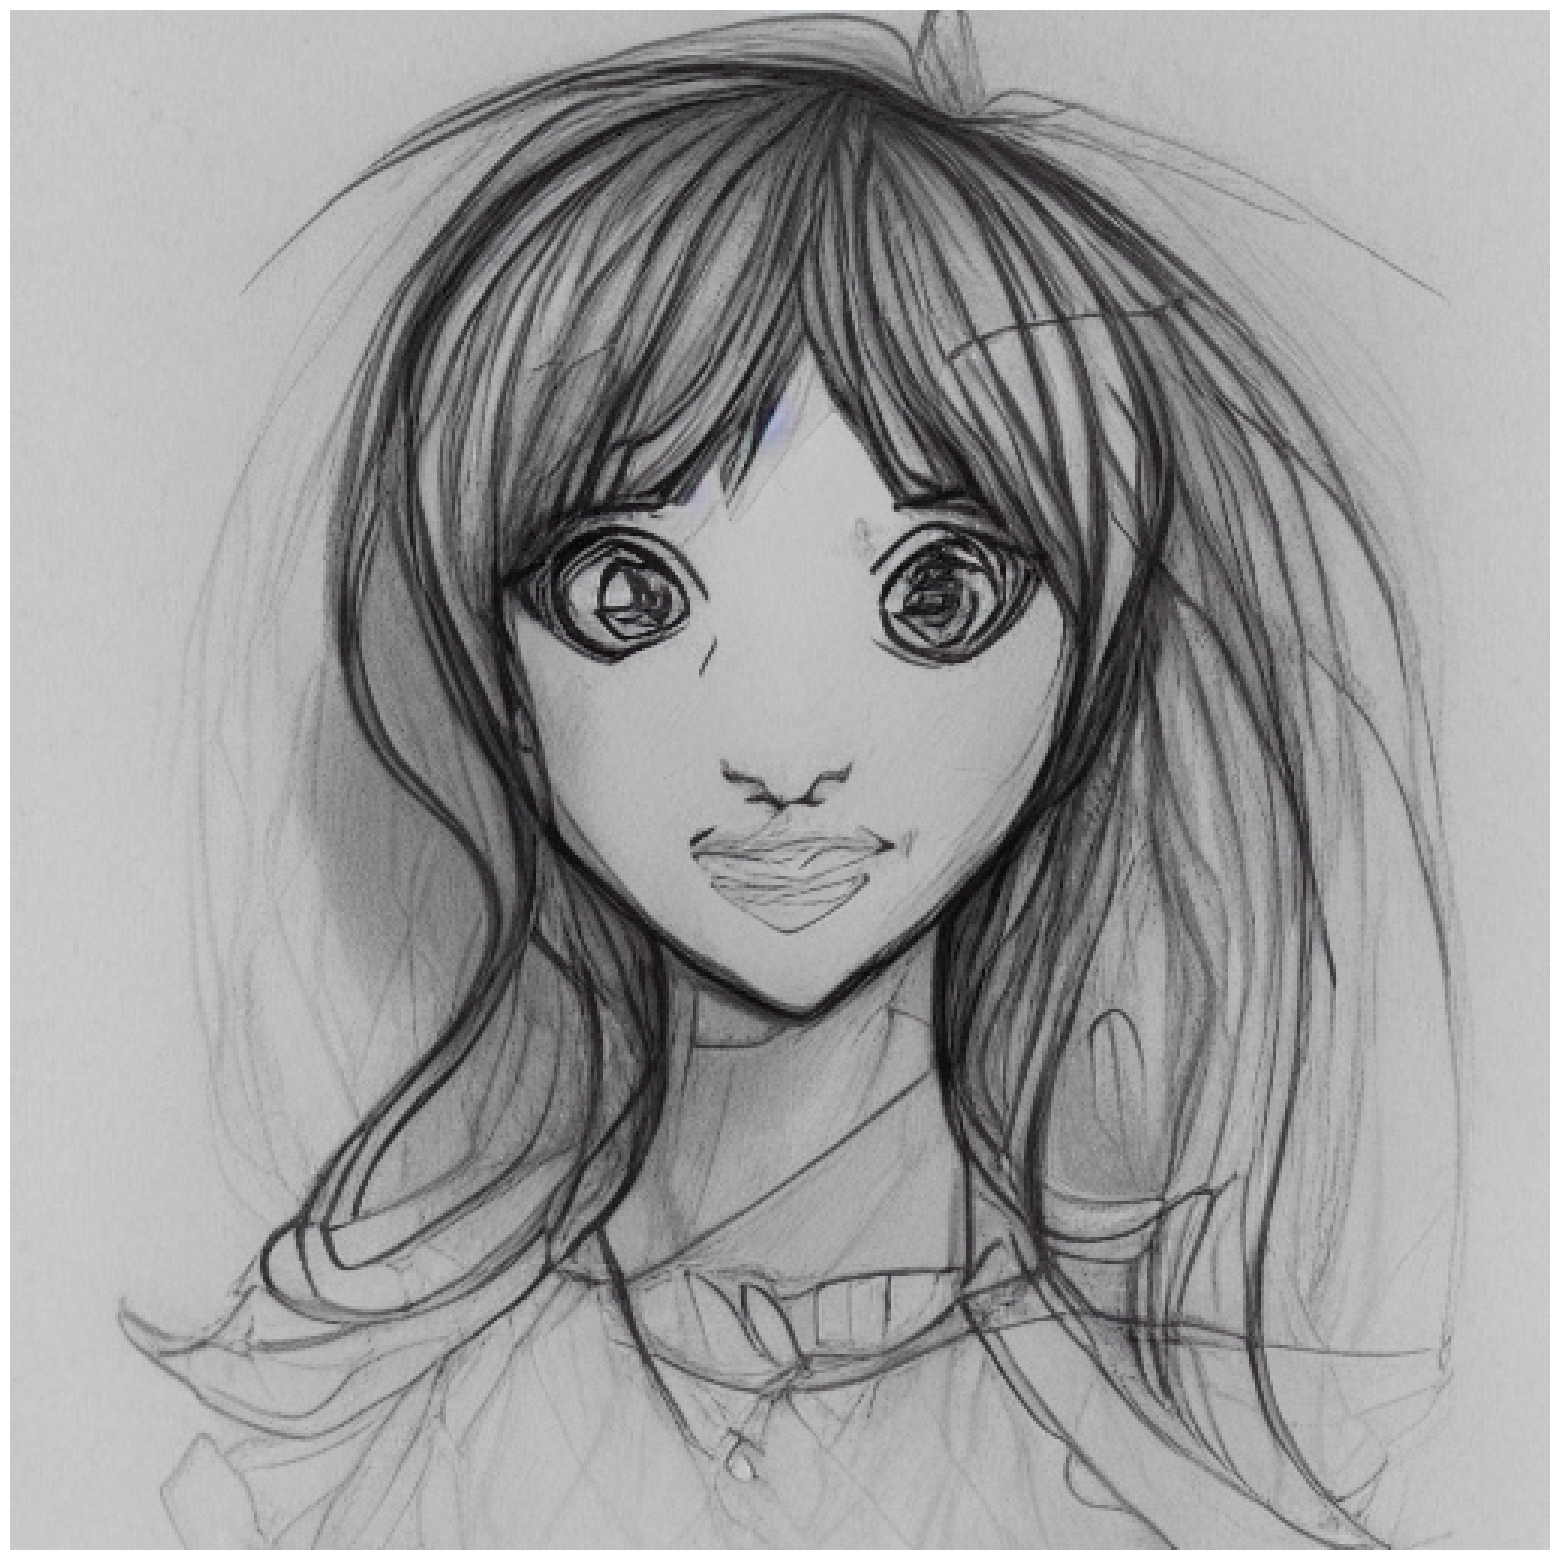

In [28]:
images = model.text_to_image("bloom sketch", batch_size=1)


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(images)

In [20]:
# https://iask.ai/
# What AI model do I need to generate an image based on text. It needs to be free. It needs to run on slow pc. 
# It needs to run locally. Not clip or GPT or DALLE. The image needs to look like a sketch. Not Sketch-RNN. 
# Give me a website on how to use it. It needs to run on a python notebook. It needs to be pre-trained.

# Out of memory!

import torch
from dalle2_pytorch import DALLE2, DiffusionPriorNetwork, DiffusionPrior, Unet, Decoder, OpenAIClipAdapter

clip = OpenAIClipAdapter()

# mock data

text = torch.randint(0, 49408, (4, 256)).cuda()
images = torch.randn(4, 3, 256, 256).cuda()

# prior networks (with transformer)

prior_network = DiffusionPriorNetwork(
    dim = 512,
    depth = 6,
    dim_head = 64,
    heads = 8
).cuda()

diffusion_prior = DiffusionPrior(
    net = prior_network,
    clip = clip,
    timesteps = 100,
    cond_drop_prob = 0.2
).cuda()

loss = diffusion_prior(text, images)
loss.backward()

# do above for many steps ...

# decoder (with unet)

unet1 = Unet(
    dim = 128,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults=(1, 2, 4, 8),
    text_embed_dim = 512,
    cond_on_text_encodings = True  # set to True for any unets that need to be conditioned on text encodings (ex. first unet in cascade)
).cuda()

unet2 = Unet(
    dim = 16,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults = (1, 2, 4, 8, 16)
).cuda()

decoder = Decoder(
    unet = (unet1, unet2),
    image_sizes = (128, 256),
    clip = clip,
    timesteps = 1000,
    sample_timesteps = (250, 27),
    image_cond_drop_prob = 0.1,
    text_cond_drop_prob = 0.5
).cuda()

for unet_number in (1, 2):
    loss = decoder(images, text = text, unet_number = unet_number) # this can optionally be decoder(images, text) if you wish to condition on the text encodings as well, though it was hinted in the paper it didn't do much
    loss.backward()

# do above for many steps

dalle2 = DALLE2(
    prior = diffusion_prior,
    decoder = decoder
)

images = dalle2(
    ['a butterfly trying to escape a tornado'],
    cond_scale = 2. # classifier free guidance strength (> 1 would strengthen the condition)
)

# save your image (in this example, of size 256x256)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 12.00 GiB total capacity; 11.29 GiB already allocated; 0 bytes free; 11.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [21]:
from torchvision.transforms import ToPILImage

print(images.shape)

for img in images:
    img = ToPILImage()(img)
    img.show()

torch.Size([4, 3, 256, 256])
